# Segmentation Exercise

In this exercise we will segment the left ventricle of the heart in relatively small images using neural networks. 
Below is the code for setting up a segmentation network and training it. The network isn't very good, **so the exercise is to improve the quality of the segmentation by improving the network and/or the training scheme including data loading efficiency and data augmentation**. 

The data being used here is derived from the [Sunnybrook Cardiac Dataset](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) of cardiac MR images, filtered to contain only left ventricular myocardium segmentations and reduced in the XY dimensions.

First we install and import MONAI plus other dependencies:

In [ ]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
%matplotlib inline

from urllib.request import urlopen
from io import BytesIO

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import monai
from monai.transforms import Compose, AddChannel, ScaleIntensity, ToTensor
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
from monai.utils import first, progress_bar
from monai.networks import one_hot

# new imports
from ignite.engine import Engine, Events
from monai.data import NPZDictItemDataset
from monai.engines import SupervisedTrainer, SupervisedEvaluator
from monai.handlers import StatsHandler, MeanDice, ValidationHandler, MetricLogger, from_engine
from monai.utils.enums import CommonKeys
from monai.networks.nets import UNet
from monai.transforms import (
    Activationsd, 
    AsDiscreted,
    AddChanneld,
    ScaleIntensityd,
    CastToTyped,
    EnsureTyped,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    Rand2DElasticd,
    RandAffined,
)

device = torch.device("cuda:0")
DATA_NPZ = "https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz"

both_keys = (CommonKeys.IMAGE, CommonKeys.LABEL)
image_only = CommonKeys.IMAGE

We now load the data from the remote source and visualize a sample:

In [2]:
# here we need to only load the npz file itself
remote_file = urlopen(DATA_NPZ)
npz = BytesIO(remote_file.read())

# data = np.load(npz)  # load all the data from the archive

# images = data["images"]  # images in BHW array order
# segs = data["segs"]  # segmentations in BHW array order
# case_indices = data["caseIndices"]  # the indices in `images` for each case

# images = images.astype(np.float32) / images.max()  # normalize images

# print(images.shape, segs.shape)
# plt.imshow(images[13] + segs[13] * 0.25, cmap="gray")  # show image 13 with segmentation

We will split our data into a training and validation set by keeping the last 6 cases as the latter:

In [10]:
# valid_index = case_indices[-6, 0]  # keep the last 6 cases for testing

# # divide the images, segmentations, and categories into train/test sets
# train_images, train_segs = images[:valid_index], segs[:valid_index]
# valid_images, valid_segs = images[valid_index:], segs[valid_index:]

We can now create a MONAI data loading object to compose batches during training, and another for validation:

In [3]:
# image_trans = Compose(
#     [
#         ScaleIntensity(),  # rescale image data to range [0,1]
#         AddChannel(),  # add 1-size channel dimension
#         ToTensor(),  # convert to tensor
#     ]
# )

# seg_trans = Compose([AddChannel(), ToTensor()])

# ds = ArrayDataset(train_images, image_trans, train_segs, seg_trans)
# loader = DataLoader(
#     dataset=ds,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     pin_memory=torch.cuda.is_available(),
# )

# val_ds = ArrayDataset(test_images, image_trans, test_segs, seg_trans)
# val_loader = DataLoader(
#     dataset=val_ds,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     pin_memory=torch.cuda.is_available(),
# )

# im, seg = first(loader)
# print(im.shape, im.min(), im.max(), seg.shape)

batch_size = 50
num_workers = 2
aug_prob = 0.5

# use these when interpolating binary segmentations to ensure values are 0 or 1 only
zoom_mode = monai.utils.enums.InterpolateMode.NEAREST
elast_mode = monai.utils.enums.GridSampleMode.BILINEAR, monai.utils.enums.GridSampleMode.NEAREST

train_trans = Compose(
    [
        ScaleIntensityd(image_only),
        AddChanneld(both_keys),
        RandRotate90d(keys=both_keys, prob=aug_prob),
        RandFlipd(keys=both_keys, prob=aug_prob),
        RandZoomd(keys=both_keys, prob=aug_prob, mode=zoom_mode),
        Rand2DElasticd(keys=both_keys, prob=aug_prob, spacing=10, magnitude_range=(-2, 2), mode=elast_mode),
#         RandAffined(keys=both_keys, prob=aug_prob, rotate_range=1, translate_range=16, mode=elast_mode),
        CastToTyped(both_keys, (np.float32, np.int32)),
        EnsureTyped(both_keys),
    ]
)

val_trans = Compose(
    [
        ScaleIntensityd(image_only),
        AddChanneld(both_keys),
        CastToTyped(both_keys, (np.float32, np.int32)),
        EnsureTyped(both_keys),
    ]
)

# create training and validation datasets from the whole set of images, these will be resized below based on case indices
train_dat = NPZDictItemDataset(npz, {"images": CommonKeys.IMAGE, "segs": CommonKeys.LABEL}, train_trans, ("caseIndices",))
val_dat = NPZDictItemDataset(npz, {"images": CommonKeys.IMAGE, "segs": CommonKeys.LABEL}, val_trans)

# extract the case indices array
case_indices = train_dat.other_keys["caseIndices"]
val_index = case_indices[-6, 0]  # keep the last 6 cases for testing

# Partition the loaded datasets, we want to keep only part of the datasets which have different transform pipelines.
# This involves multiple copies of the data which is fine for small datasets like this, but how would this be avoided?
train_dat = train_dat[:val_index]
val_dat = val_dat[val_index:]

loader = DataLoader(
    dataset=train_dat,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

val_loader = DataLoader(
    dataset=val_dat,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

We now define out simple network. This doesn't do a good job so consider how to improve it by adding layers or other elements:

In [8]:
# class SegNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.model = nn.Sequential(
#             # layer 1: convolution, normalization, downsampling
#             nn.Conv2d(1, 2, 3, 1, 1),
#             nn.BatchNorm2d(2),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2, 1),
#             # layer 2
#             nn.Conv2d(2, 4, 3, 1, 1),
#             # layer 3
#             nn.ConvTranspose2d(4, 2, 3, 2, 1, 1),
#             nn.BatchNorm2d(2),
#             nn.ReLU(),
#             # layer 4: output
#             nn.Conv2d(2, 1, 3, 1, 1),
#         )

#     def forward(self, x):
#         return self.model(x)

Our training scheme is very simple. For each epoch we train on each batch of images from the training set, thus training with each image once, and then evaluate with the validation set.

In [4]:
num_epochs = 200
lr = 5e-3

# net = SegNet()
# net = net.to(device)

# opt = torch.optim.Adam(net.parameters(), lr)
# loss = DiceLoss(sigmoid=True)
# metric = DiceMetric(include_background=True, reduction="mean")

# step_losses = []
# epoch_metrics = []
# total_step = 0

# for epoch in range(num_epochs):
#     net.train()

#     # train network with training images
#     for bimages, bsegs in loader:
#         bimages = bimages.to(device)
#         bsegs = bsegs.to(device)

#         opt.zero_grad()

#         prediction = net(bimages)
#         loss_val = loss(torch.sigmoid(prediction), bsegs)
#         loss_val.backward()
#         opt.step()

#         step_losses.append((total_step, loss_val.item()))
#         total_step += 1

#     net.eval()
#     metric_vals = []

#     # test our network using the validation dataset
#     with torch.no_grad():
#         for bimages, bsegs in val_loader:
#             bimages = bimages.to(device)
#             bsegs = bsegs.to(device)

#             prediction = net(bimages)

#             mvals = metric(y_pred=torch.sigmoid(prediction) > 0.5, y=bsegs)
#             metric_vals += mvals.cpu().data.numpy().flatten().tolist()

#     epoch_metrics.append((total_step, np.average(metric_vals)))

#     progress_bar(epoch + 1, num_epochs, f"Validation Metric: {epoch_metrics[-1][1]:7.3}")

net = UNet(dimensions=2, in_channels=1, out_channels=1, channels=[16, 32, 64], strides=[2, 2])
net = net.to(device)

opt = torch.optim.Adam(net.parameters(), lr)
loss = DiceLoss(sigmoid=True)
metric = DiceMetric(include_background=True, reduction="mean")

step_losses = []
epoch_metrics = []
total_step = 0

post_transform = Compose(
    [Activationsd(keys="pred", sigmoid=True), AsDiscreted(keys=["pred", "label"], threshold_values=True,),]
)


evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    postprocessing=post_transform,
    key_val_metric={"val_mean_dice": MeanDice(include_background=True, output_transform=from_engine(["pred", "label"]))},
    val_handlers=[StatsHandler(output_transform=lambda x: None)],
)

logger = MetricLogger(evaluator=evaluator)

trainer = SupervisedTrainer(
    device=device,
    max_epochs=num_epochs,
    train_data_loader=loader,
    network=net,
    optimizer=opt,
    loss_function=loss,
    train_handlers=[logger, ValidationHandler(1, evaluator)],
)


@trainer.on(Events.EPOCH_COMPLETED)
def _progress(engine: Engine):
    m = evaluator.state.metrics["val_mean_dice"]
    progress_bar(engine.state.epoch, num_epochs, f"Validation Metric: {m:7.3}")


trainer.run()

200/200 Validation Metric:   0.749 [==============================]


We now graph the results from our training and find the results are not very good:

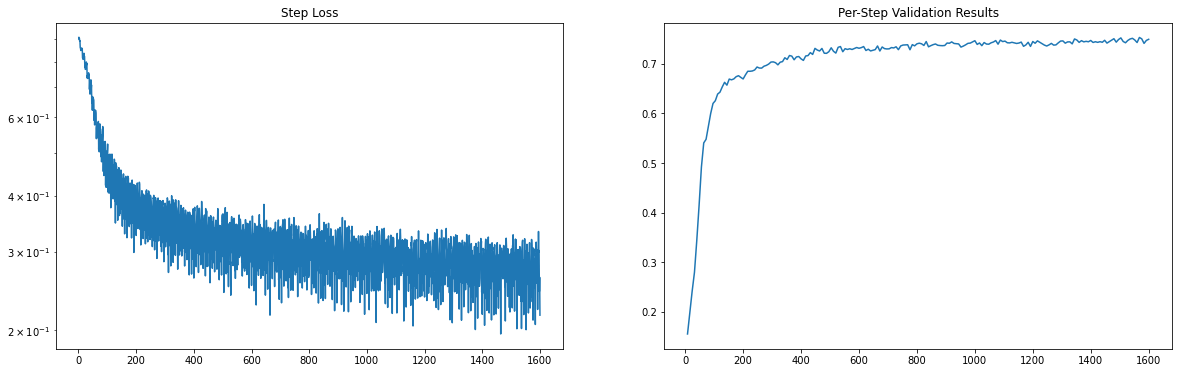

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

step_losses=logger.loss
epoch_metrics=logger.metrics["val_mean_dice"]

ax[0].semilogy(*zip(*step_losses))
ax[0].set_title("Step Loss")

ax[1].plot(*zip(*epoch_metrics))
ax[1].set_title("Per-Step Validation Results")
plt.show()

## 👉 Challenge: Improve results and implementation 👈

### 1. Improve Data Pipeline

The pipeline currently has a very basic set of transforms. We'd want to add new transforms which will add regularization to our training process, specifically modifying the image and segmentations to make the learning problem a little harder. 

The dataset being used is `ArrayDataset` but we have in MONAI `NPZDictItemDataset` for loading data from Numpy's NPZ file format. Change the code to use this class instead. You'll need a different way of getting `caseIndices` and splitting the dataset using it.

### 2. Improve/Replace Network

As you can see we're not getting good results from our network. The training loss values are jumping around and not decreasing much anymore. The validation score has topped out at 0.25, which is really poor. 

It's now up to you to improve the results of our segmentation task. The things to consider changing include the network itself, how data is loaded, how batches might be composed, and what transforms we want to use from MONAI. 

### 3. Replace The Training Loop

This notebook uses a simple training loop with validation done explicitly. Replace this with a use of the `SupervisedTrainer` class and `SupervisedEvaluator` to do the evaluation throughout the training process. The graph plotting is done simply by recording values at each iteration through the loop, you'll want to use some other mechanism to do the same thing such as using a `MetricLogger` handler object.